<a href="https://colab.research.google.com/github/149189/Sentiment-Analysis-on-IMDb-Reviews/blob/main/Sentiment_Analysis_on_IMDb_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
pip install tensorflow transformers datasets


In [25]:
pip install --upgrade tensorflow transformers


In [26]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt

In [27]:
from datasets import load_dataset

# Load the IMDb dataset
dataset = load_dataset("imdb")

# Display a few examples from the training dataset
print("Training Dataset Examples:")
for i in range(3):
    print(f"Example {i+1}:")
    print(f"Text: {dataset['train'][i]['text']}")
    print(f"Label: {dataset['train'][i]['label']}")
    print()

# Display a few examples from the test dataset
print("Test Dataset Examples:")
for i in range(3):
    print(f"Example {i+1}:")
    print(f"Text: {dataset['test'][i]['text']}")
    print(f"Label: {dataset['test'][i]['label']}")
    print()


Training Dataset Examples:
Example 1:
Text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex an

In [28]:
small_train_dataset = dataset['train'].select(range(500))
small_test_dataset = dataset['test'].select(range(500))

print(len(small_train_dataset))
print(len(small_test_dataset))

500
500


In [29]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)

small_train_dataset = small_train_dataset.map(preprocess_function, batched=True)
small_test_dataset = small_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [31]:
small_train_dataset = small_train_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=True,
    batch_size=32  # Larger batch size for faster training
)

small_test_dataset = small_test_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=32
)

In [32]:
optimizer = Adam(learning_rate=3e-5)
loss_fn = SparseCategoricalCrossentropy(from_logits=True)
accuracy_metric = SparseCategoricalAccuracy()

# Lists to store accuracy and loss
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

In [33]:
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training step
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for batch in small_train_dataset:
        input_ids = batch[0]["input_ids"]
        attention_mask = batch[0]["attention_mask"]
        labels = batch[1]

        with tf.GradientTape() as tape:
            logits = model(input_ids, attention_mask=attention_mask, training=True).logits
            loss = loss_fn(labels, logits)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        epoch_loss_avg.update_state(loss)
        epoch_accuracy.update_state(labels, logits)

    # Log training results
    train_losses.append(epoch_loss_avg.result().numpy())
    train_accuracies.append(epoch_accuracy.result().numpy())
    print(f"Training loss: {train_losses[-1]}, accuracy: {train_accuracies[-1]}")

    # Validation step
    val_loss_avg = tf.keras.metrics.Mean()
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for batch in small_test_dataset:
        input_ids = batch[0]["input_ids"]
        attention_mask = batch[0]["attention_mask"]
        labels = batch[1]

        logits = model(input_ids, attention_mask=attention_mask, training=False).logits
        loss = loss_fn(labels, logits)

        val_loss_avg.update_state(loss)
        val_accuracy.update_state(labels, logits)

    # Log validation results
    val_losses.append(val_loss_avg.result().numpy())
    val_accuracies.append(val_accuracy.result().numpy())
    print(f"Validation loss: {val_losses[-1]}, accuracy: {val_accuracies[-1]}")

Epoch 1/3
Training loss: 0.21097029745578766, accuracy: 0.9779999852180481
Validation loss: 0.04766467586159706, accuracy: 1.0
Epoch 2/3
Training loss: 0.02542431838810444, accuracy: 1.0
Validation loss: 0.010228879749774933, accuracy: 1.0
Epoch 3/3
Training loss: 0.008301490917801857, accuracy: 1.0
Validation loss: 0.004956250544637442, accuracy: 1.0


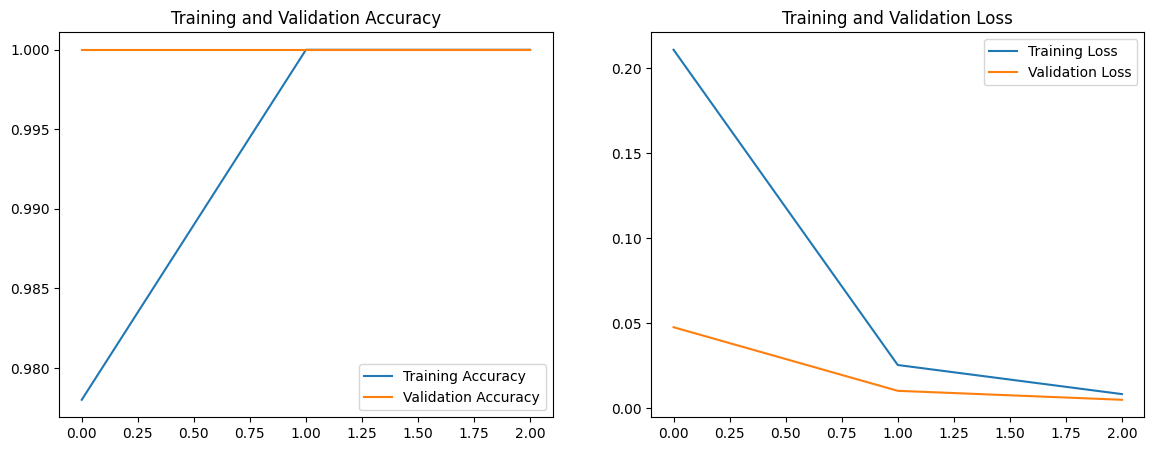

In [34]:
epochs_range = range(epochs)

plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

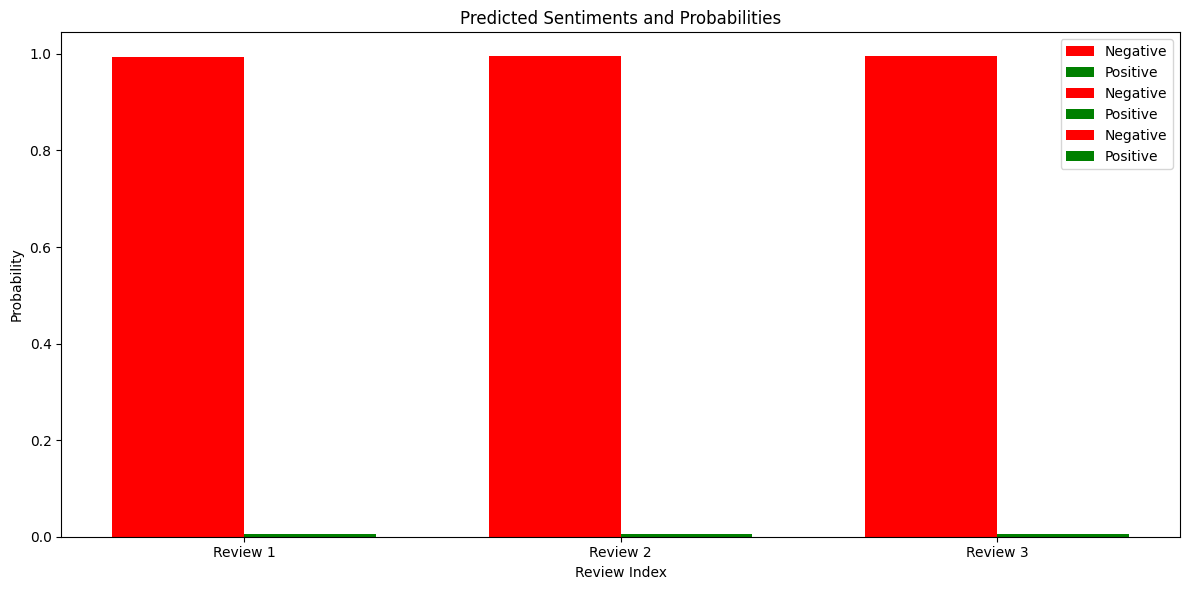

Review 1: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967.
Predicted Sentiment: Negative
Probabilities: [0.9946571  0.00534286]

Review 2: If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.
Predicted Sentiment: Negative
Probabilities: [0.99497885 0.00502111]

Review 3: An average movie with some entertaining moments, but it lacked depth.
Predicted Sentiment: Negative
Probabilities: [0.9948472  0.00515283]



In [38]:
import matplotlib.pyplot as plt
import numpy as np

def predict_sentiments_visual(text_data, model, tokenizer):
    # Initialize lists to store results
    sentiments = []
    probabilities_list = []

    # Iterate over each review in the text_data
    for review_text in text_data:
        # Preprocess the input review
        inputs = tokenizer(review_text, padding='max_length', truncation=True, max_length=64, return_tensors="tf")

        # Get model predictions
        logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask']).logits
        predictions = tf.nn.softmax(logits, axis=-1)

        # Get the predicted class (0 or 1)
        predicted_class = tf.argmax(predictions, axis=-1).numpy()[0]

        # Map the predicted class to sentiment
        sentiment = "Positive" if predicted_class == 1 else "Negative"

        # Append results to lists
        sentiments.append(sentiment)
        probabilities_list.append(predictions.numpy()[0])

    # Visualization
    num_reviews = len(text_data)
    x = np.arange(num_reviews)  # The label locations

    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35  # Width of the bars

    # Create bars for each review's probabilities
    for i, (probabilities, sentiment) in enumerate(zip(probabilities_list, sentiments)):
        bars = ax.bar(x[i] - bar_width / 2, probabilities[0], bar_width, label='Negative', color='red')
        bars = ax.bar(x[i] + bar_width / 2, probabilities[1], bar_width, label='Positive', color='green')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Review Index')
    ax.set_ylabel('Probability')
    ax.set_title('Predicted Sentiments and Probabilities')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Review {i+1}' for i in x])
    ax.legend()

    plt.tight_layout()
    plt.show()

    return sentiments, probabilities_list

# Example usage
text_data = [
    "I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967.",
    "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.",
    "An average movie with some entertaining moments, but it lacked depth."
]

sentiments, probabilities = predict_sentiments_visual(text_data, model, tokenizer)

for i, (review_text, sentiment) in enumerate(zip(text_data, sentiments)):
    print(f"Review {i+1}: {review_text}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Probabilities: {probabilities[i]}")
    print()
